In [26]:
import numpy as np
import matplotlib.pyplot as plt


# 출력문 번역


- common/util.py

In [9]:
# 말뭉치 전처리
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [31]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [6]:
# 단어 ID 목록
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [10]:
# 단어에서 단어 ID로의 딕셔너리
word_to_id

{'.': 6, '1': 4, 'and': 3, 'goodbye': 2, 'hello': 5, 'say': 1, 'you': 0}

In [11]:
# 단어 ID에서 단어로 딕셔너리
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: '1', 5: 'hello', 6: '.'}

## 동시발생 행렬(Co-occurrence matrix)
- 분포 가설에 기초해 단어를 벡터로 나타내는 방법
- 어떤 단어에 주목했을 때, 그 주변에 어떤 단어가 몇 번이나 등장하는지를 세어 집계하는 방법


In [14]:
C = np.array([
[0, 1, 0, 0, 0, 0, 0],
[1, 0, 1, 0, 1, 1, 0],
[0, 1, 0, 1, 0, 0, 0],
[0, 0, 1, 0, 1, 0, 0],
[0, 1, 0, 1, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 1],
[0, 0, 0, 0, 0, 1, 0],
], dtype=np.int32)

동시발생 행렬을 사용하면 다음과 같은 방식으로 각 단
어의 벡터를 얻을 수 있습니다.


In [15]:
print(C[0]) # ID가 0인 단어의 벡터 표현
#[0100000]
print(C[4]) # ID가 4인 단어의 벡터 표현
#[0101000]
print(C[word_to_id[ 'goodbye' ]]) # "goodbye"의 벡터 표현
# "goodbye"의 벡터 표현
#[0101000]

[0 1 0 0 0 0 0]
[0 1 0 1 0 0 0]
[0 1 0 1 0 0 0]


In [ ]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    '''동시발생 행렬 생성
    :param corpus: 말뭉치(단어 ID 목록)
    :param vocab_size: 어휘 수
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: 동시발생 행렬
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

## 벡터 간 유사도
단어 벡터의 유사도를 나타낼 때는 코사인 유사도(cosine similarity)를 자주 이용합니다.

코사인 유사도를 직관적으로 풀어보자면 •두 벡터가 가리키는 방향이 얼마나 비슷한가’입니다. 두
벡터의 방향이 완전히 같다면 코사인 유사도가 1 이 되며, 완전히 반대라면 -1 이 됩니다.

```
def cos_siinilarity(x, y):
    nx = x / np.sqrt(np.s니m(x **2)) # 乂의 정규화
    ny = y / np.sqrt(np.sum(y **2) ) # y으I 정규화
    return np.dot(nx, ny)
```

인수로 제로 벡터 (원소가 모두 0인 벡터 )가 들어오면
‘0으로 나누기divide by zer。’ 오류가 발생해버립니다. 

작은 값을 뜻하는 eps를 인수로 받도록 하고, 이 인수의 값을 지정

In [16]:
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

In [17]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
c0 = C[word_to_id['you']] # "you"의 단어 벡터
cl = C[word_to_id['i']] # "i"의 단어 벡터

print(cos_similarity(c0, cl))

0.7071067691154799


실행 결과 “you”와 “『의 코사인 유사도는 0.70...으로 나왔습니다. 코사인 유사도 값은 -1에
서 1 사이이므로, 이 값은 비교적 높다(유사성이 크다)고 말할 수 있습니다.

## 유사단어의 랭킹 표시
어떤 단어가 검색어로 주어지면. 그 검색어와 비슷한 단어를 유사도 순으로 출력하는 함수


In [20]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''유사 단어 검색
    :param query: 쿼리(텍스트)
    :param word_to_id: 단어에서 단어 ID로 변환하는 딕셔너리
    :param id_to_word: 단어 ID에서 단어로 변환하는 딕셔너리
    :param word_matrix: 단어 벡터를 정리한 행렬. 각 행에 해당 단어 벡터가 저장되어 있다고 가정한다.
    :param top: 상위 몇 개까지 출력할 지 지정
    '''
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
     
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

In [21]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
c0 = C[word_to_id['you']] # "you"의 단어 벡터
cl = C[word_to_id['i']] # "i"의 단어 벡터

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


“goodbye”와 “hello”의 코사인 유사도가 높다는 것은
우리의 직관과는 거리가 멀죠. 물론 지금은 말뭉치의 크기가 너무 작다는 것이 원인

# 통계 기반 기법 개선하기

## 상호정보량
동시발생 행렬의 원소는 두 단어가 동시에 발생한 횟수를 나타냅니다. 말뭉치에서 “the”와 “car”의 동시발생을 생각해보죠. 분명 the car ...”라는 문구가
자주 보일 겁니다. 따라서 두 단어의 동시발생 횟수는 아주 많겠죠. 한편, “car”와 “drive”는확
실히 관련이 깊습니다. 하지만 단순히 등장 횟수만을 본다면 “car”는 “drive”보다는 “the”와의
관련성이 훨씬 강하다고 나올 겁니다. “the”가 고빈도 단어라서 “car”와 강한 관련성을 갖는다
고 평가되기 때문이죠.

이 문제를 해결하기 위해 점별 상호정보량P*twiseMumallnf<,mwton [1 이 (pMl) 이라는 척도를 사용한답니다.



In [23]:
def ppmi(C, verbose=False, eps = 1e-8):
    '''PPMI(점별 상호정보량) 생성
    :param C: 동시발생 행렬
    :param verbose: 진행 상황을 출력할지 여부
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100 + 1) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M

In [24]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


PPMI 행렬에도 여전히 큰 문제가 있습니다! 말뭉치의 어휘 수가 증가함에 따라 각 단
어 벡터의 차원 수도 증가한다는 문제죠. 예를 들어 말뭉치의 어휘 수가 10만 개라면 그 벡터의 차원 수도 똑같이 10만이 됩니다. 10만 차원의 벡터를 다룬다는 것은 그다지 현실적이지 않습니다.

또한, 이 행렬의 내용을 들여다보면 원소 대부분이 0인 것을 알 수 있습니다. 벡터의 원소 대부분이 중요하지 않다는 뜻이죠. 다르게 표현하면 각 원소의 ‘중요도’가 낮다는 뜻입 니다. 더구나이런 벡터는 노이즈에 약하고 견고하지 못하다는 약점도 있지요. 이 문제에 대처하고자 자주 수행하는 기법이 바로 벡터의 차원 감소입니다.



# 차원 감소dimensionality reduction
벡터의 차원을 줄이는 방법을 말합니다. 그러나 단순
히 줄이기만 하는 게 아니라, ‘중요한 정보’는 최대한 유지하면서 줄이는 게 핵심입니다.

차원을 감소시키는 방법은 여 러 가지 입니다만, 우리는 특잇값분해（SVD）를
이용하겠습니다.

$$ X = USV^T$$

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01 -1.110e-16 -1.205e-01 -4.163e-16 -9.323e-01 -1.110e-16
 -2.426e-17]


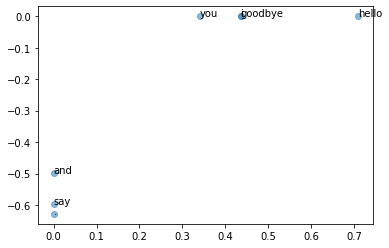

In [27]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print(C[0])
print(W[0])
print(U[0])

# 플롯
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

이 밀집벡터의 차원을 감소시키려면, 예컨대 2차워 벡터로 줄이려면 단순히 처음의 두
원소를 꺼내면 됩니다.

In [28]:
U[0, :2]

array([ 3.409e-01, -1.110e-16], dtype=float32)

계속해서 PTB 데이터셋이라는 더 큰 말뭉
치를 사용하여 똑같은 실험을 수행해봅시다.

펜 트리뱅크 Penn Treebank (PTB)

```
PTB 말뭉치는 word2vec의 발명자인 토마스 미콜로프의 웹 페이
지에서 받을 수 있습니다. 이 PTB 말뭉치는 텍스트 파일로 제공되며, 원래의 PTB 문장에 몇
가지 전처리를 해두었습니다. 예컨대 희소한 단어를〈unk〉라는 특수 문자로 치환한다거나
（“link”는 “unknown”의 약어）, 구체적인 숫자를 “N”으로 대체하는 등의 작업이 적용되었습
니다.
```

- PTB 말뭉치（텍스트 파일）의 예

```
1 consumers may want to move their telephones a little closer to the tv set
2 <unk> <unk> watching abc "s monday night footbail can now vote during <unk> for the greatest play in N years from
among four or five <unk> <unk>
3 two weeks ago viewers of several nbc <unk> consumer segments started calling a N number for advice on various
<unk> issues
4 and the new syndicated reality show hard copy records viewers ' opinions for possible airing on the next day's show
5 interactive telephone technotogy has taken a new leap in <unk> and television programmers are racing to exploit the
possibilities
6 eventually viewers may grow <unk> with the technology and <unk> the cost
```

In [29]:
import sys
sys.path.append('..')
import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

Done
말뭉치 크기: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


## PTB 데이터셋 평가

In [30]:

window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산 ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # truncated SVD (빠르다!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (느리다)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

동시발생 수 계산 ...
PPMI 계산 ...
1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
calculating SVD ...

[query] you
 i: 0.6486228108406067
 we: 0.607466459274292
 anybody: 0.5